<a href="https://colab.research.google.com/github/Magidares/Uni/blob/main/Prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-20-aa7f1106d560>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


Epoch  0 MSE:  0.15716975927352905
Epoch  1 MSE:  0.09330084174871445
Epoch  2 MSE:  0.08263444155454636
Epoch  3 MSE:  0.08106257021427155
Epoch  4 MSE:  0.06651602685451508
Epoch  5 MSE:  0.061036620289087296
Epoch  6 MSE:  0.05452946200966835
Epoch  7 MSE:  0.03674616664648056
Epoch  8 MSE:  0.01728278398513794
Epoch  9 MSE:  0.03279636427760124
Epoch  10 MSE:  0.007418958470225334
Epoch  11 MSE:  0.02229597419500351
Epoch  12 MSE:  0.02640753984451294
Epoch  13 MSE:  0.015365726314485073
Epoch  14 MSE:  0.005286659579724073
Epoch  15 MSE:  0.012015859596431255
Epoch  16 MSE:  0.013590232469141483
Epoch  17 MSE:  0.0055481321178376675
Epoch  18 MSE:  0.004476398695260286
Epoch  19 MSE:  0.007880530320107937
Epoch  20 MSE:  0.009802647866308689
Epoch  21 MSE:  0.008616728708148003
Epoch  22 MSE:  0.0057138679549098015
Epoch  23 MSE:  0.0037763332948088646
Epoch  24 MSE:  0.004544191528111696
Epoch  25 MSE:  0.006362705025821924
Epoch  26 MSE:  0.006100553087890148
Epoch  27 MSE:  0.0

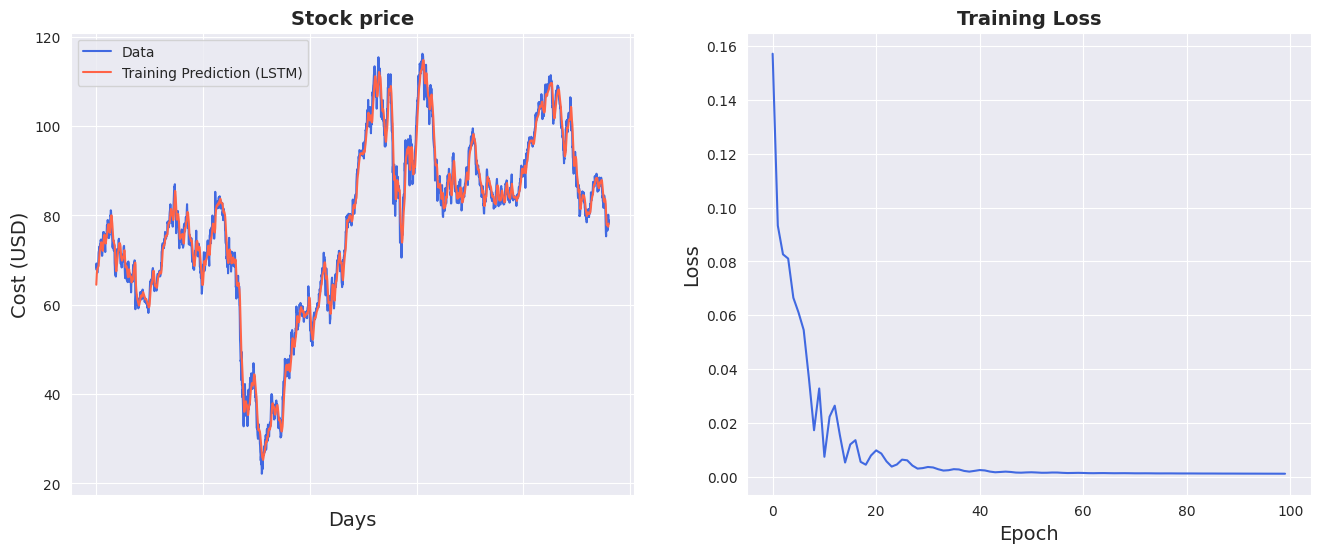

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0),
    self.hidden_dim).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0),
    self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:, -1, :])
    return out

def split_data(stock, lookback):
  data_raw = stock.to_numpy() # convert to numpy array
  data = []
  # create all possible sequences of length seq_len
  for index in range(len(data_raw) - lookback):
    data.append(data_raw[index: index + lookback])
  data = np.array(data);
  test_set_size = int(np.round(0.2*data.shape[0]));
  train_set_size = data.shape[0] - (test_set_size);
  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size,-1,:]
  x_test = data[train_set_size:,:-1]
  y_test = data[train_set_size:,-1,:]
  return [x_train, y_train, x_test, y_test]

data = pd.read_csv('/content/CAT_2006-01-01_to_2018-01-01.csv')

price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim,
output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
  y_train_pred = model(x_train)
  loss = criterion(y_train_pred, y_train_lstm)
  print("Epoch ", t, "MSE: ", loss.item())
  hist[t] = loss.item()
  optimiser.zero_grad()
  loss.backward()
  optimiser.step()
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

sns.set_style("darkgrid")
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0],
label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0],
label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)

<ipython-input-10-bebc5d6755f0>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


Epoch  0 MSE:  0.11935707181692123
Epoch  1 MSE:  1.2918239831924438
Epoch  2 MSE:  0.2836085259914398
Epoch  3 MSE:  1.9508233070373535
Epoch  4 MSE:  5.303374290466309
Epoch  5 MSE:  0.49886271357536316
Epoch  6 MSE:  0.13958440721035004
Epoch  7 MSE:  0.43572279810905457
Epoch  8 MSE:  0.21342359483242035
Epoch  9 MSE:  0.24030815064907074
Epoch  10 MSE:  0.23067858815193176
Epoch  11 MSE:  0.03946553170681
Epoch  12 MSE:  0.172026589512825
Epoch  13 MSE:  0.024333279579877853
Epoch  14 MSE:  0.058560118079185486
Epoch  15 MSE:  0.024740377441048622
Epoch  16 MSE:  0.02703544683754444
Epoch  17 MSE:  0.026722125709056854
Epoch  18 MSE:  0.030550511553883553
Epoch  19 MSE:  0.022492995485663414
Epoch  20 MSE:  0.006393228657543659
Epoch  21 MSE:  0.021238934248685837
Epoch  22 MSE:  0.00887379702180624
Epoch  23 MSE:  0.014352892525494099
Epoch  24 MSE:  0.004019879270344973
Epoch  25 MSE:  0.010181253775954247
Epoch  26 MSE:  0.003425501985475421
Epoch  27 MSE:  0.005788782611489296

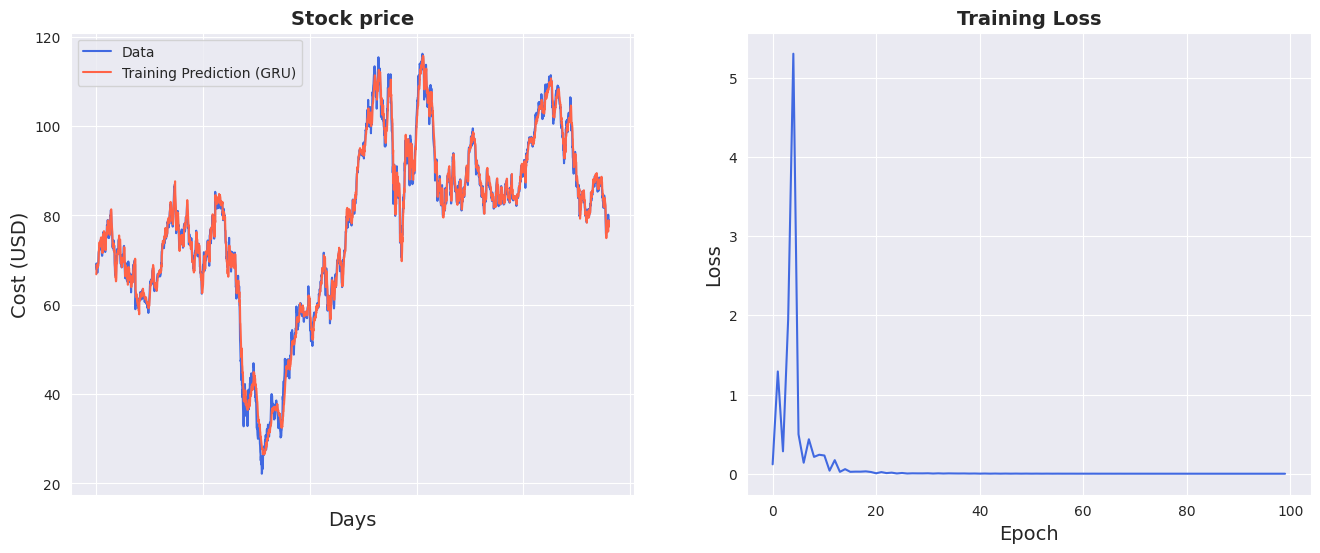

In [10]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class GRU(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
    super(GRU, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn) = self.gru(x, (h0.detach()))
    out = self.fc(out[:, -1, :])
    return out

def split_data(stock, lookback):
  data_raw = stock.to_numpy() # convert to numpy array
  data = []
  # create all possible sequences of length seq_len
  for index in range(len(data_raw) - lookback):
    data.append(data_raw[index: index + lookback])
  data = np.array(data);
  test_set_size = int(np.round(0.2*data.shape[0]));
  train_set_size = data.shape[0] - (test_set_size);
  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size,-1,:]
  x_test = data[train_set_size:,:-1]
  y_test = data[train_set_size:,-1,:]
  return [x_train, y_train, x_test, y_test]

data = pd.read_csv('/content/CAT_2006-01-01_to_2018-01-01.csv')

price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim,
output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)

hist = np.zeros(num_epochs)
start_time = time.time()
gpu = []
for t in range(num_epochs):
  y_train_pred = model(x_train)
  loss = criterion(y_train_pred, y_train_lstm)
  print("Epoch ", t, "MSE: ", loss.item())
  hist[t] = loss.item()
  optimiser.zero_grad()
  loss.backward()
  optimiser.step()
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

sns.set_style("darkgrid")
fig = plt.figure(figsize=(16,4))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0],
label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0],
label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)
plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)